<a href="https://colab.research.google.com/github/dfridland/PyTorch/blob/HW8/PyTorchHW8GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
class GraphGenerator(torch.utils.data.Dataset):
    rng = np.random.default_rng(seed=6)
    eps = np.finfo(np.float32).eps
    def __init__(self, low, high, length, noise_intensity=0.1):
        self.x = GraphGenerator.rng.uniform(low, high, length) + GraphGenerator.eps
        self.noise = GraphGenerator.rng.normal(-noise_intensity, noise_intensity, length)
        self.graph = np.sin(self.x) / self.x - self.x / 10
        self.values = self.graph + self.graph.std() * self.noise
        self.points = np.c_[self.x, self.values]

    def __getitem__(self, index):
        return self.points[index]

    def __len__(self):
        return self.x.shape[0]

    def graph_draw(self, fake_points=None, size=(10, 5), thick=20):
        plt.figure(figsize=size)
        plt.title('Graph')
        idx = self.x.argsort()
        plt.scatter(self.x, self.values, s=thick, label='true points')
        if fake_points is not None:
            plt.scatter(fake_points[0], fake_points[1], s=thick, label='fake points', color='blue', marker='x', alpha=0.7)
        plt.plot(self.x[idx], self.graph[idx], color='red', lw=2.5, alpha=0.7, label=r'$y(x) = \frac{sin(x)}{x} - \frac{x}{10}$')
        plt.legend(loc=3, prop={'size': 12})
        plt.show()

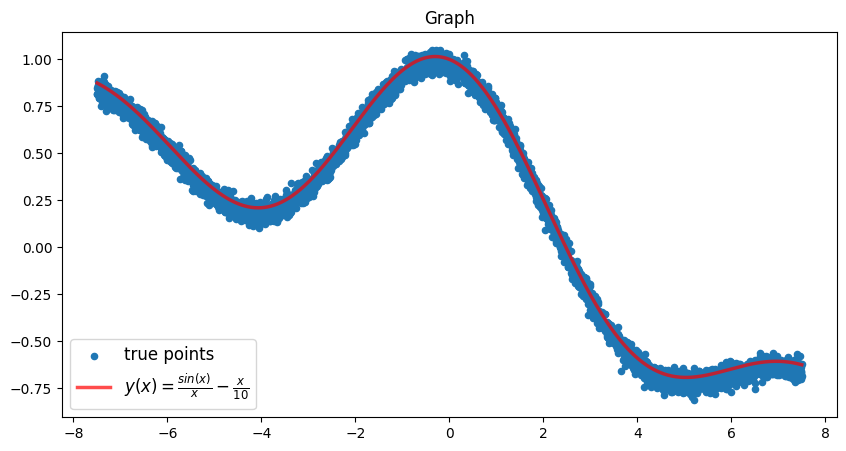

In [11]:
batch_size = 128
low_bound = -7.5
upper_bound = 7.5
points = 5000

dataset = GraphGenerator(low_bound, upper_bound, points, noise_intensity=0.05)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset.graph_draw()

In [12]:
class Generator(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.activations = nn.ModuleDict({
            'lrelu': nn.LeakyReLU(0.2, inplace=True),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid()})

        self.gen_model = torch.nn.Sequential(
            *self.block(dim, 2 * dim, 'relu', need_normalize=True, drop_factor=0.05),
            *self.block(2 * dim, dim, 'relu', need_normalize=True, drop_factor=0.05),
            *self.block(dim, 2, 'lrelu', need_normalize=True, drop_factor=0.05),
        )

    def block(self, in_dim, out_dim, activation='lrelu', need_normalize=False, drop_factor=0.1):
        layers = [torch.nn.Linear(in_dim, out_dim), self.activations[activation]]
        if need_normalize:
            layers.append(torch.nn.BatchNorm1d(out_dim))
        if drop_factor:
            layers.append(torch.nn.Dropout(drop_factor))
        return layers

    def forward(self, x):
        return self.gen_model(x)

In [13]:
class Discriminator(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.activations = nn.ModuleDict({
            'lrelu': nn.LeakyReLU(0.2, inplace=True),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid()})

        self.model = torch.nn.Sequential(
            *self.block(2, dim, 'lrelu', need_normalize=False, drop_factor=0.05),
            *self.block(dim, 2 * dim, 'lrelu', need_normalize=False, drop_factor=0.05),
            *self.block(2 * dim, dim, 'lrelu', need_normalize=False, drop_factor=0.05),
            *self.block(dim, 1, 'sigmoid', need_normalize=False, drop_factor=None),
        )

    def block(self, in_dim, out_dim, activation, need_normalize=False, drop_factor=0.1):
        layers = [torch.nn.Linear(in_dim, out_dim), self.activations[activation]]
        if need_normalize:
            layers.append(torch.nn.BatchNorm1d(out_dim))
        if drop_factor:
            layers.append(torch.nn.Dropout(drop_factor))
        return layers

    def forward(self, x):
        return self.model(x)

In [14]:
torch.manual_seed(11)
LR = 0.001
gen_hidden_dim = 96
dis_hidden_dim = 48
b1 = 0.5
b2 = 0.999

generator = Generator(dim=gen_hidden_dim).to(device)
discriminator = Discriminator(dim=dis_hidden_dim).to(device)
optimizer_g = torch.optim.Adam(
    generator.parameters(),
    lr=LR,
    betas=(b1, b2)
)
optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr=LR,
    betas=(b1, b2)
)

adversarial_loss = torch.nn.BCELoss()

In [15]:
n_epochs = 10

d_loss_history = []
g_loss_history = []

In [17]:

generator.train()
discriminator.train()

for ep in range(n_epochs):
    pbar = tqdm(loader, total=len(loader), desc=f'Epoch {ep}/{n_epochs}')
    for batch in pbar:
        # generating labels for postive and negative classes 
        true_class = torch.ones(batch.shape[0], 1, device=device)
        false_class = torch.zeros(batch.shape[0], 1, device=device)

   
        # getting true values
        true_points = batch.float().to(device)
        # generating reporiductive data to feed discriminator
        fake_data = torch.rand(batch.shape[0], gen_hidden_dim, device=device)
        fake_points = generator(fake_data)
        # discriminator distinguishing real data from generated data.
        # discriminator forecasting based on real data, 
        true_pred = discriminator(true_points)
        # giving generated data to discriminator 
        fake_pred = discriminator(fake_points)
        # calculating discrimitor's loss
        true_loss = adversarial_loss(true_pred, true_class)
        fake_loss = adversarial_loss(fake_pred, false_class)
        d_loss = (true_loss + fake_loss) / 2
        d_loss_history.append(d_loss.item())

        #discriminator learning step
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # generating reporiductive data to feed generator
        fake_data = torch.rand(batch.shape[0], gen_hidden_dim, device=device)
        fake_points = generator(fake_data)

        #getting dicriminator forecasting for newly generated  data (by generator)
        fake_pred = discriminator(fake_points)

        #calclulating generator loss
        g_loss =  adversarial_loss(fake_pred, true_class)
        g_loss_history.append(g_loss.item())

        #generator learning step
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        pbar.set_postfix({'Generator loss': g_loss.item(), 'Discriminator loss': d_loss.item()})

Epoch 9/10: 100%|██████████| 40/40 [00:00<00:00, 46.48it/s, Generator loss=1.87, Discriminator loss=0.646]


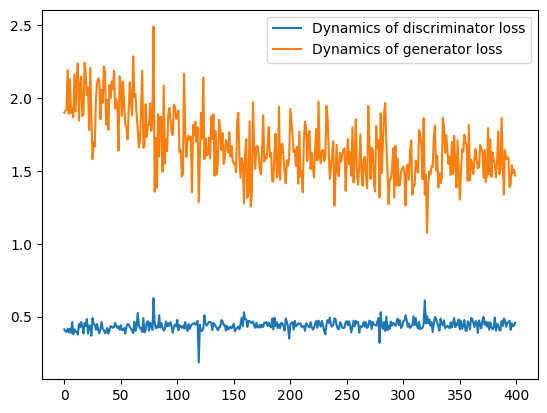

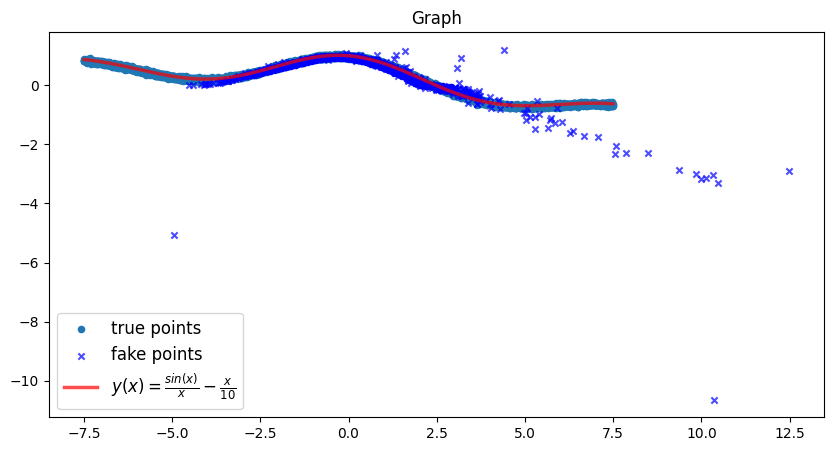

In [19]:
# просмотр результатов
plt.plot(d_loss_history, label='Dynamics of discriminator loss')
plt.plot(g_loss_history, label='Dynamics of generator loss')
plt.legend()
plt.show()

generator.eval()
fake_data = torch.rand(2500, gen_hidden_dim, device=device)
fake_points = generator(fake_data).detach().to(device)
dataset.graph_draw(fake_points.T)